# Deep dream

Gradient ascent applied to existing pictures instead of random noise

see also http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html

In [1]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.


In [2]:
base_image_path = "kremsater.jpg"
result_prefix = "dream"

In [3]:
# These are the names of the layers for which we try to maximize activation,
# as well as their weight in the final loss we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}


In [4]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


In [5]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


In [7]:
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


In [8]:
K.set_learning_phase(0)

In [9]:
# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input

In [10]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict 

{'activation_1': <keras.layers.core.Activation at 0x7fa4aff10fd0>,
 'activation_10': <keras.layers.core.Activation at 0x7fa4afbb5e48>,
 'activation_11': <keras.layers.core.Activation at 0x7fa4afb1fcf8>,
 'activation_12': <keras.layers.core.Activation at 0x7fa4afafae48>,
 'activation_13': <keras.layers.core.Activation at 0x7fa4afa65cf8>,
 'activation_14': <keras.layers.core.Activation at 0x7fa4af9bfba8>,
 'activation_15': <keras.layers.core.Activation at 0x7fa4af9adda0>,
 'activation_16': <keras.layers.core.Activation at 0x7fa4af904e48>,
 'activation_17': <keras.layers.core.Activation at 0x7fa4af8ddf28>,
 'activation_18': <keras.layers.core.Activation at 0x7fa4af84bf60>,
 'activation_19': <keras.layers.core.Activation at 0x7fa4af820ba8>,
 'activation_2': <keras.layers.core.Activation at 0x7fa4afeb5860>,
 'activation_20': <keras.layers.core.Activation at 0x7fa4af790fd0>,
 'activation_21': <keras.layers.core.Activation at 0x7fa4af766dd8>,
 'activation_22': <keras.layers.core.Activation at

In [11]:
# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

In [12]:
# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

In [13]:
# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


In [14]:
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

In [15]:
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.

In [16]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

In [17]:
img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]

In [18]:
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [19]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)


Processing image shape (1020, 1530)
..Loss value at 0 : 0.898909
..Loss value at 1 : 1.26393
..Loss value at 2 : 1.65727
..Loss value at 3 : 2.05033
..Loss value at 4 : 2.43989
..Loss value at 5 : 2.82499
..Loss value at 6 : 3.20913
..Loss value at 7 : 3.59014
..Loss value at 8 : 3.97076
..Loss value at 9 : 4.36088
..Loss value at 10 : 4.73815
..Loss value at 11 : 5.11676
..Loss value at 12 : 5.49999
..Loss value at 13 : 5.87856
..Loss value at 14 : 6.23548
..Loss value at 15 : 6.61678
..Loss value at 16 : 7.01234
..Loss value at 17 : 7.40962
..Loss value at 18 : 7.78373
..Loss value at 19 : 8.18256
Processing image shape (1428, 2142)
..Loss value at 0 : 1.51951
..Loss value at 1 : 2.38799
..Loss value at 2 : 3.13952
..Loss value at 3 : 3.78441
..Loss value at 4 : 4.39028
..Loss value at 5 : 4.97759
..Loss value at 6 : 5.54457
..Loss value at 7 : 6.09689
..Loss value at 8 : 6.6392
..Loss value at 9 : 7.17724
..Loss value at 10 : 7.70561
..Loss value at 11 : 8.23076
..Loss value at 12 :

/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


..Loss value at 0 : 1.45308
..Loss value at 1 : 2.28178
..Loss value at 2 : 3.04369
..Loss value at 3 : 3.73
..Loss value at 4 : 4.37259
..Loss value at 5 : 5.01648
..Loss value at 6 : 5.64982
..Loss value at 7 : 6.26977
..Loss value at 8 : 6.89551
..Loss value at 9 : 7.50718
..Loss value at 10 : 8.13801
..Loss value at 11 : 8.73771
..Loss value at 12 : 9.34505
..Loss value at 13 : 9.96175


In [20]:
save_img(img, fname=result_prefix + '.png')

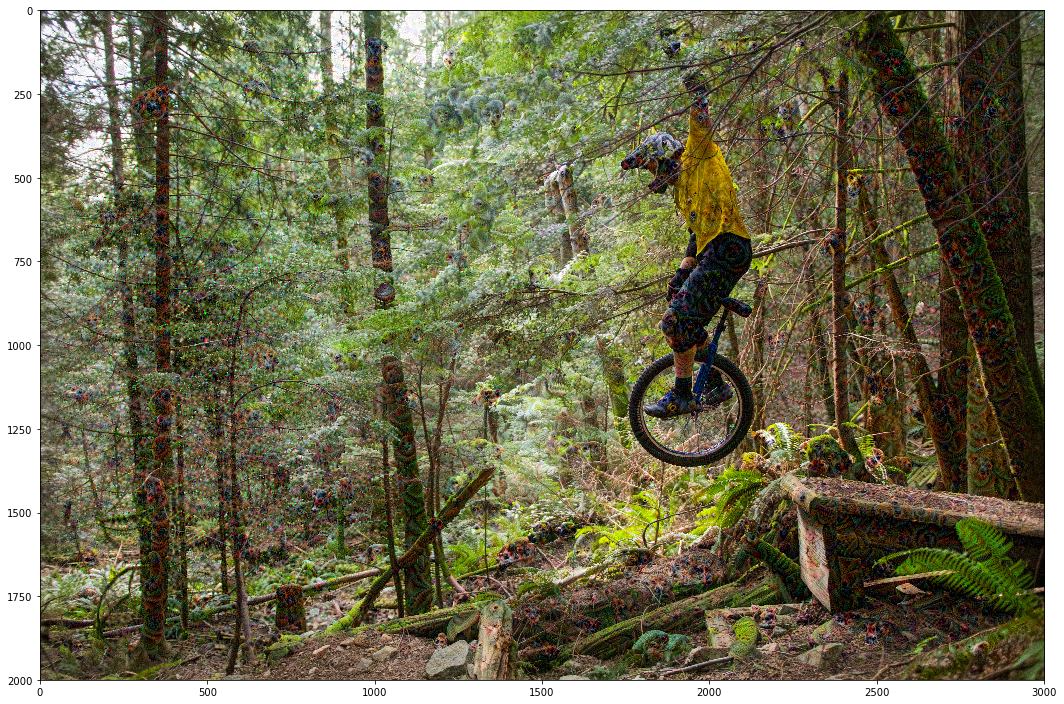

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,18)

pil_img = deprocess_image(np.copy(img))
plt.imshow(pil_img)